# Теория

Уменьшение размерности --  задача из машинного обучения (изначально -- из статистики), где алгоритм "собирает" многочисленные признаки в высокоуровневые абстракции.

**Где используется уменьшение размерности:**<br>
- Рекомендательные системы
- Риск-менеджмент
- Красивые визуализации
- Определение похожих текстов (тематическое моделирование)


**Популярные алгоритмы:** <br>
- Метод главных компонент (PCA)
- Латентное размещение Дирихле (LDA)
- Сингулярное разложение (SVD)
- t-SNE, UMAP (для визуализации)

**Как работает объединение признаков в абстракцию:**<br>
 - CV: "собака с треугольными ушами" + "с длинным носом" + "с большим хвостом" >> овчарка
 - NLP:  текст с фразами "нарезать кубиками", "200 грамм", "при температуре" >> кулинарный рецепт
 - RecSys: "пользователь слушает Alice Coltrane" + "лайкнул альбом Луи Армстронга" >> любитель джаза

! *важно отметить, что не все абстракции хорошо интерпретируемы (тк мы работаем с многомерными пространствами)*

Уменьшение размерности хорошо работает для определения тематик текстов (Topic Modelling). Идея такая же: документ с текстом представляют как некоторую абстракцию из более низкоуровневых признаков. 

# Практика

Сегодня будем делать топик-моделлинг на [корпусе новостей](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset)

наши алгоритмы --- LDA (Latent Dirichlet Allocation), SVD (Single Value Decomosition) и NMF (Non-negative Matrix Factorization).

## LDA

![](LDA.png)

[ссылка на картинку](https://www.mygreatlearning.com/blog/understanding-latent-dirichlet-allocation/#:~:text=LDA%20Algorithm,by%20a%20statistical%20generative%20process.&text=In%20the%20process%20of%20generating,the%20multinomial%20topic%2Dword%20distributions.)

- Корпус -- это коллекция из D документов.

- Документ состоит из N слов.

- В одном документе может встретиться K тем.

Слова в корпусе -- единственная явная переменная. Скрытые (латентные) переменные - это распределение тем в корпусе и распределение слов в документе. Задача алгоритма LDA -- используя наблюдаемые слова извлечь информацию о структуре тем в корпусе.

Для LDA нужны две матрицы: *“темы x слова"* и  *“документы x темы”*. 
Они получаются из матрицы "документы x слова"

In [14]:
import matplotlib.pyplot as plt # viz
%matplotlib inline
import seaborn as sns
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # векторизация текстов
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF # dimred = dimensionality reduction (matrix decomposition)

from sklearn.datasets import fetch_20newsgroups # data

import warnings
warnings.filterwarnings("ignore")

In [2]:
# зададим несколько переменных, будем использовать их как параметры функций

n_samples = 2000 # размер корпуса
n_features = 1000 # максимальное количество слов в матрице "слово x документ" (= top1000 частотных их всех в корпусе)
n_components = 10 # число тем в корпусе
n_top_words = 20 # порог частотности для визуализаций

Сначала загрузим датасет и возьмем оттуда только текстовую часть (без заголовков, сносок и тд)

In [3]:
# если возникает ошибка загрузки, раскомментьте ячейки ниже
# import ssl
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context


data, _ = fetch_20newsgroups(remove=('headers', 'footers','quotes'), # we need only article text, no headers, footers, or quotes
                             return_X_y=True) # y (разметка по темам) нам не нужен, на самом деле (мы удаляем его в переменной data: до запятой Х, после запятой у, в нашем случае прочерк)

len(data)

['I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.',
 "A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't an

In [11]:
# data[0]
len(data)

11314

In [37]:
# для работы возьмем часть датасета
# data_samples = data[:n_samples] # first 2000 docs
data_samples = pd.DataFrame(data).sample(n = n_samples)[0].to_list() # 2000 random docs (convert to df, sample, convert back to list)
print("Общий датасет: {} документов;\nФрагмент для работы: {} документов".format(len(data),len(data_samples)))


Общий датасет: 11314 документов;
Фрагмент для работы: 2000 документов


Теперь документы надо векторизовать

In [38]:
# we can use tfidf vectorizer or some other frequency measure
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, # игнорируем слова,которые только в 1 доке или в 95% документов.
                                max_features=n_features,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(data_samples)

In [39]:
display(type(tf_vectorizer))
display(type(tf))

sklearn.feature_extraction.text.CountVectorizer

scipy.sparse.csr.csr_matrix

In [42]:
display(tf.shape) # docs x terms

tf_vectorizer.get_feature_names()[995:1000]

(2000, 1000)

['years', 'yes', 'yesterday', 'york', 'young']

Теперь отдадим эту матрицу алгоритму снижения размерности

параметры в скобках: 
- n_components: число тем в корпусе
-  max_iter: количество итераций алгоритма
- learning_offset: параметр, который занижает значение ранних итераций (тк более важная часть обучения случается на поздних), обычно устанавливается больше чем 1 

[про модель](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#examples-using-sklearn-decomposition-latentdirichletallocation)

In [56]:
print(tf[0]) # first doc and its terms (how frequent they are)

  (0, 649)	1
  (0, 186)	1
  (0, 640)	1
  (0, 672)	2
  (0, 994)	1
  (0, 793)	1
  (0, 581)	1
  (0, 498)	1
  (0, 305)	1
  (0, 891)	1
  (0, 900)	1
  (0, 367)	1
  (0, 901)	1


In [59]:
tf_vectorizer.get_feature_names()[672] # word with index 672

'people'

In [43]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=20,learning_offset=50)

lda.fit(tf)

LatentDirichletAllocation(learning_offset=50, max_iter=20)

In [55]:
lda.components_.shape # topics x words

(10, 1000)

In [70]:
lda.components_[:,:10]

array([[2.73432179e+01, 1.00010653e-01, 4.92593116e+00, 1.76882371e+00,
        1.00000000e-01, 1.00000000e-01, 1.00000000e-01, 6.82638690e+00,
        1.00006064e-01, 7.96731375e+00],
       [1.11007344e+02, 1.06173368e+02, 3.44874984e+01, 2.79336685e+01,
        1.00005241e-01, 1.00000000e-01, 1.00000000e-01, 1.84625830e+02,
        6.04095724e+01, 1.10006126e+02],
       [1.00018190e-01, 1.26268271e+01, 1.00023641e-01, 1.00010465e-01,
        1.00000000e-01, 1.00000000e-01, 1.00000000e-01, 2.51434604e+01,
        2.81922737e+00, 2.50997605e+01],
       [1.00012696e-01, 1.00012987e-01, 8.20951888e-01, 2.93107519e+00,
        1.00001064e-01, 1.00000000e-01, 1.00000000e-01, 1.98310898e+01,
        2.87865748e+00, 2.33226684e+01],
       [1.00011730e-01, 1.00003257e-01, 3.16557699e+00, 9.97179116e+00,
        1.00001246e-01, 1.00000000e-01, 1.00000000e-01, 2.47557981e+01,
        1.64525401e+00, 1.00031091e-01],
       [1.00017365e-01, 1.00027151e-01, 1.00013203e-01, 1.00023229e-01,
   

используем функцию для упрощения визуализации топа частотности по темам:  

In [72]:
def plot_top_words(model, feature_names, n_top_words, title):
    
    fig, axes = plt.subplots(2, 5, figsize=(30, 15)) # параметры отображения 
    axes = axes.flatten()
    all_features = {} # словарь для сохранения ключевых слов для тем
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1] 
        top_features = [feature_names[i] for i in top_features_ind]
        # строка для сохранения темы и слов в словарь
        
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.show()

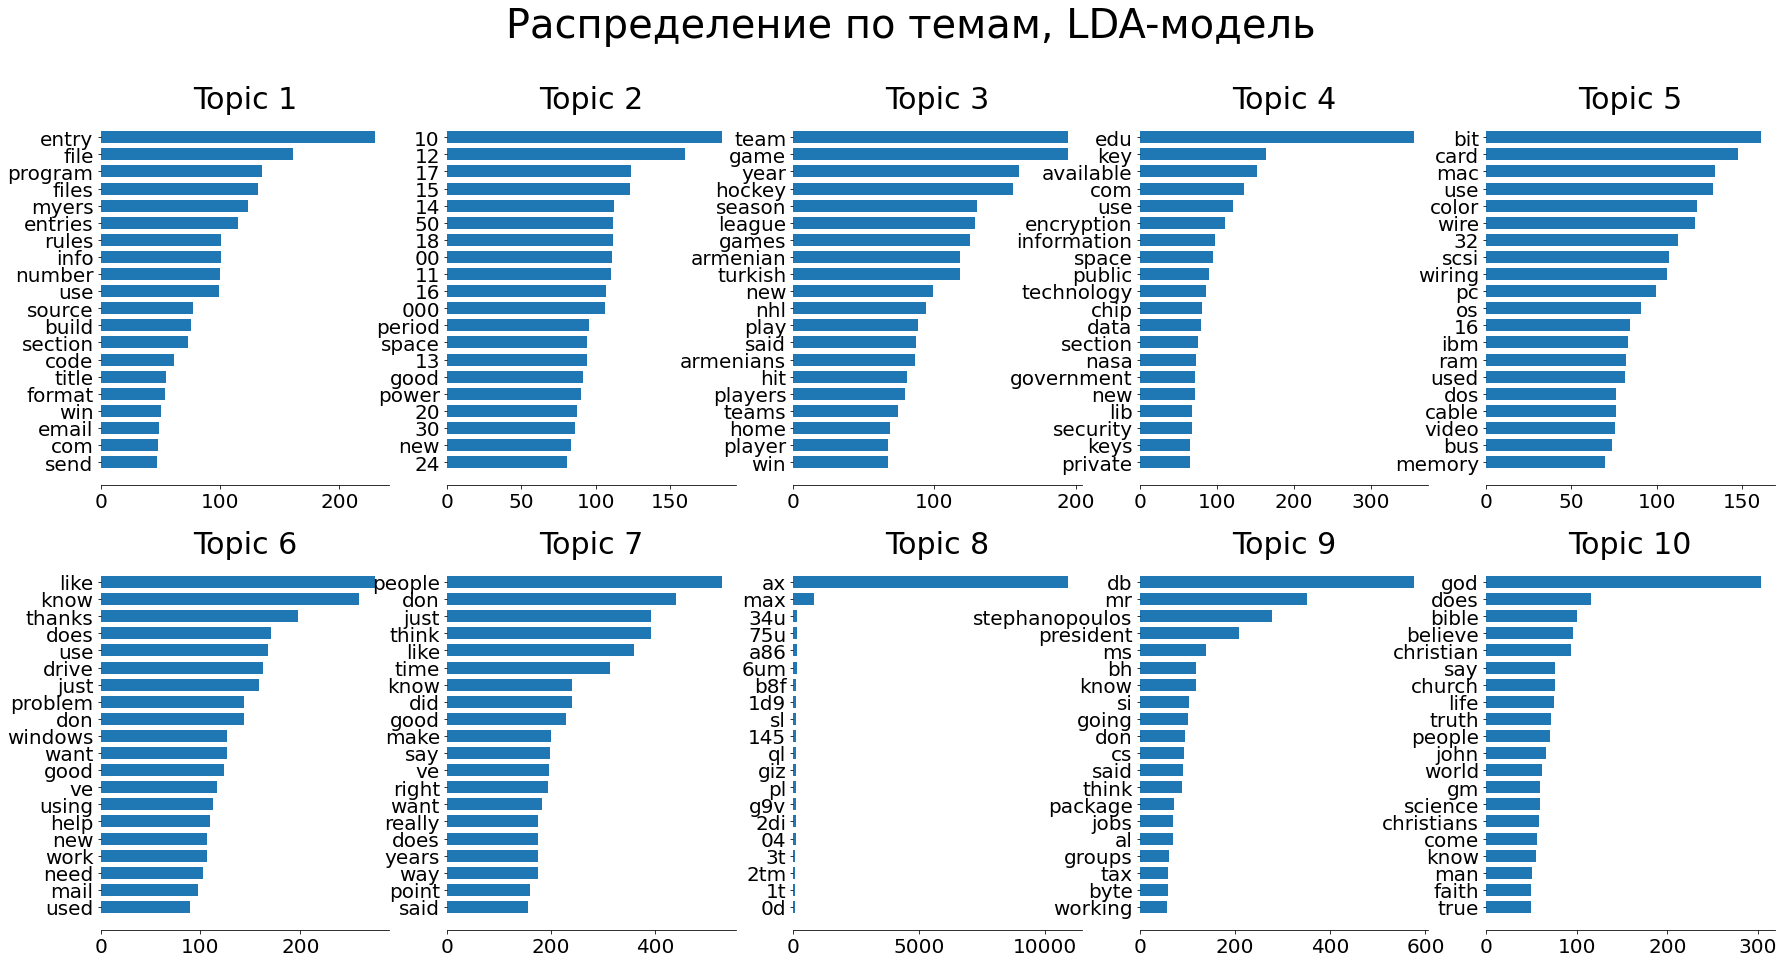

In [73]:
tf_feature_names = tf_vectorizer.get_feature_names()

plot_top_words(lda, tf_feature_names, n_top_words, 'Распределение по темам, LDA-модель')

In [74]:
# как определить тему документа
# https://stackoverflow.com/questions/45145368/python-scikit-learn-get-documents-per-topic-in-lda

def print_top_words(model, feature_names, n_top_words):
    all_features = {}
    
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
#         all_features.update((topic_idx," ".join([feature_names[i]
#                         for i in topic.argsort()[:-n_top_words - 1:-1]]).split()))
#     return all_features


In [75]:
print_top_words(lda,tf_feature_names, n_top_words)

Topic #0:
entry file program files myers entries rules info number use source build section code title format win email com send
Topic #1:
10 12 17 15 14 50 18 00 11 16 000 period space 13 good power 20 30 new 24
Topic #2:
team game year hockey season league games armenian turkish new nhl play said armenians hit players teams home player win
Topic #3:
edu key available com use encryption information space public technology chip data section nasa government new lib security keys private
Topic #4:
bit card mac use color wire 32 scsi wiring pc os 16 ibm ram used dos cable video bus memory
Topic #5:
like know thanks does use drive just problem don windows want good ve using help new work need mail used
Topic #6:
people don just think like time know did good make say ve right want really does years way point said
Topic #7:
ax max 34u 75u a86 6um b8f 1d9 sl 145 ql giz pl g9v 2di 04 3t 2tm 1t 0d
Topic #8:
db mr stephanopoulos president ms bh know si going don cs said think package jobs al gro

## Распределение документов по темам

In [78]:
doc_topic = lda.transform(tf) # docs x topics
doc_topic.shape

(2000, 10)

In [82]:
for n in range(doc_topic.shape[0])[:10]: # first 10 docs with most relevant topics
    topic_most_pr = doc_topic[n].argmax()+1
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

doc: 0 topic: 7

doc: 1 topic: 3

doc: 2 topic: 7

doc: 3 topic: 10

doc: 4 topic: 7

doc: 5 topic: 1

doc: 6 topic: 6

doc: 7 topic: 1

doc: 8 topic: 3

doc: 9 topic: 3



In [81]:
data_samples[1]

"\nLinares has not defected; as I pointed out, MLB requires that the player\ndefect first.\n\n\nWhat a surprise.  As long as the pool of talent is not accessible to all\nteams, MLB won't let a few teams sign it.  Seems perfectly reasonable to\nme.  \n\n\nExcept that MLB won't allow it, which is all I ever said."

## SVD

Уменьшение размерности с помощью метода SVD часто называется латентным семантическим анализом (LSA)

[про модель](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

In [83]:
# обучаем модель
lsa_model = TruncatedSVD(n_components=n_components)

lsa_topic_matrix = lsa_model.fit_transform(tf)

In [84]:
lsa_topic_matrix.shape # words x topics

(2000, 10)

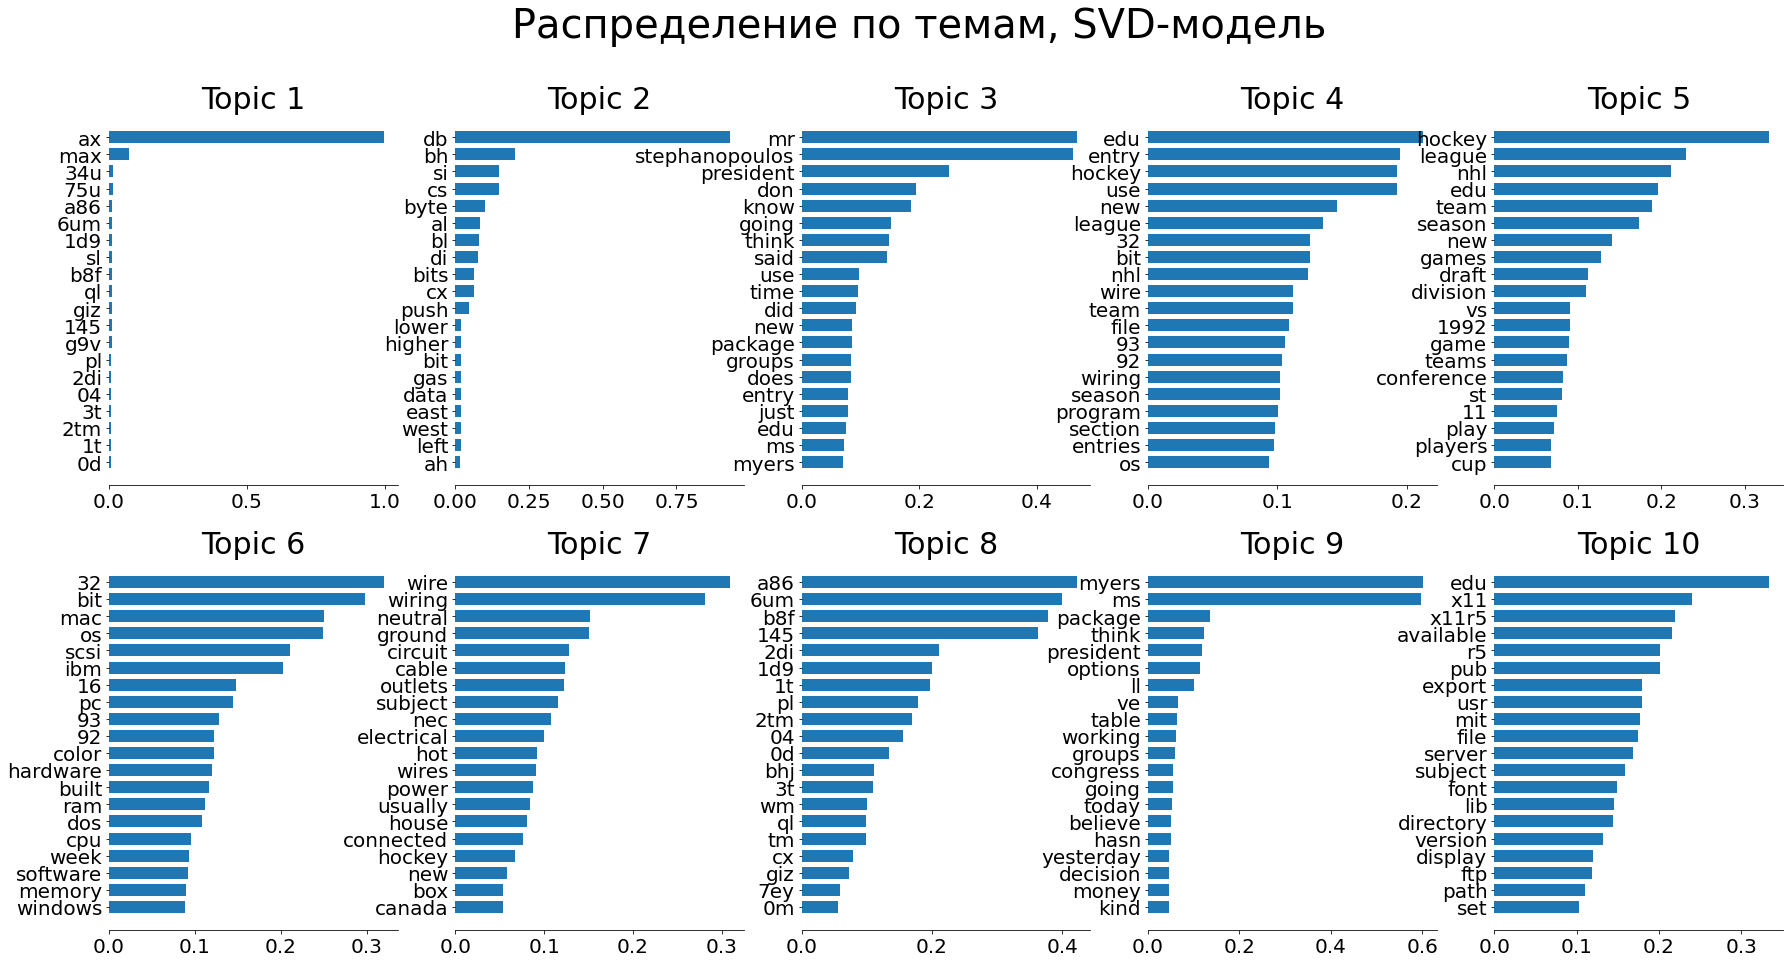

In [85]:
tf_feature_names = tf_vectorizer.get_feature_names()

plot_top_words(lsa_model, tf_feature_names, n_top_words, 'Распределение по темам, SVD-модель')

In [88]:
print_top_words(lsa_model, tf_feature_names, 10)

Topic #0:
ax max 34u 75u a86 6um 1d9 sl b8f ql
Topic #1:
db bh si cs byte al bl di bits cx
Topic #2:
mr stephanopoulos president don know going think said use time
Topic #3:
edu entry hockey use new league 32 bit nhl wire
Topic #4:
hockey league nhl edu team season new games draft division
Topic #5:
32 bit mac os scsi ibm 16 pc 93 92
Topic #6:
wire wiring neutral ground circuit cable outlets subject nec electrical
Topic #7:
a86 6um b8f 145 2di 1d9 1t pl 2tm 04
Topic #8:
myers ms package think president options ll ve table working
Topic #9:
edu x11 x11r5 available r5 pub export usr mit file


In [90]:
for n in range(lsa_topic_matrix.shape[0])[:10]: # first 10 docs and their most relevant topics
    topic_most_pr = lsa_topic_matrix[n].argmax()+1
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

doc: 0 topic: 3

doc: 1 topic: 3

doc: 2 topic: 3

doc: 3 topic: 3

doc: 4 topic: 3

doc: 5 topic: 1

doc: 6 topic: 3

doc: 7 topic: 4

doc: 8 topic: 5

doc: 9 topic: 4



##  NMF
NMF -- альтернативный способ разложения матрицы, который подразумевает, что данные не-негативные (т.е. >=0). 
NMF часто заменяет PCA. При разложении изначальная матрица превращается в две, при этом оптимизируются два параметра: расстояние между матрицами и их произведение.


[про модель](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF)

In [91]:
# для NMF понадобится tf-idf-векторизация, тк tf-idf не бывает негативным

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(data_samples)


In [92]:
# обучаем первую модель

nmf = NMF(n_components=n_components).fit(tfidf)

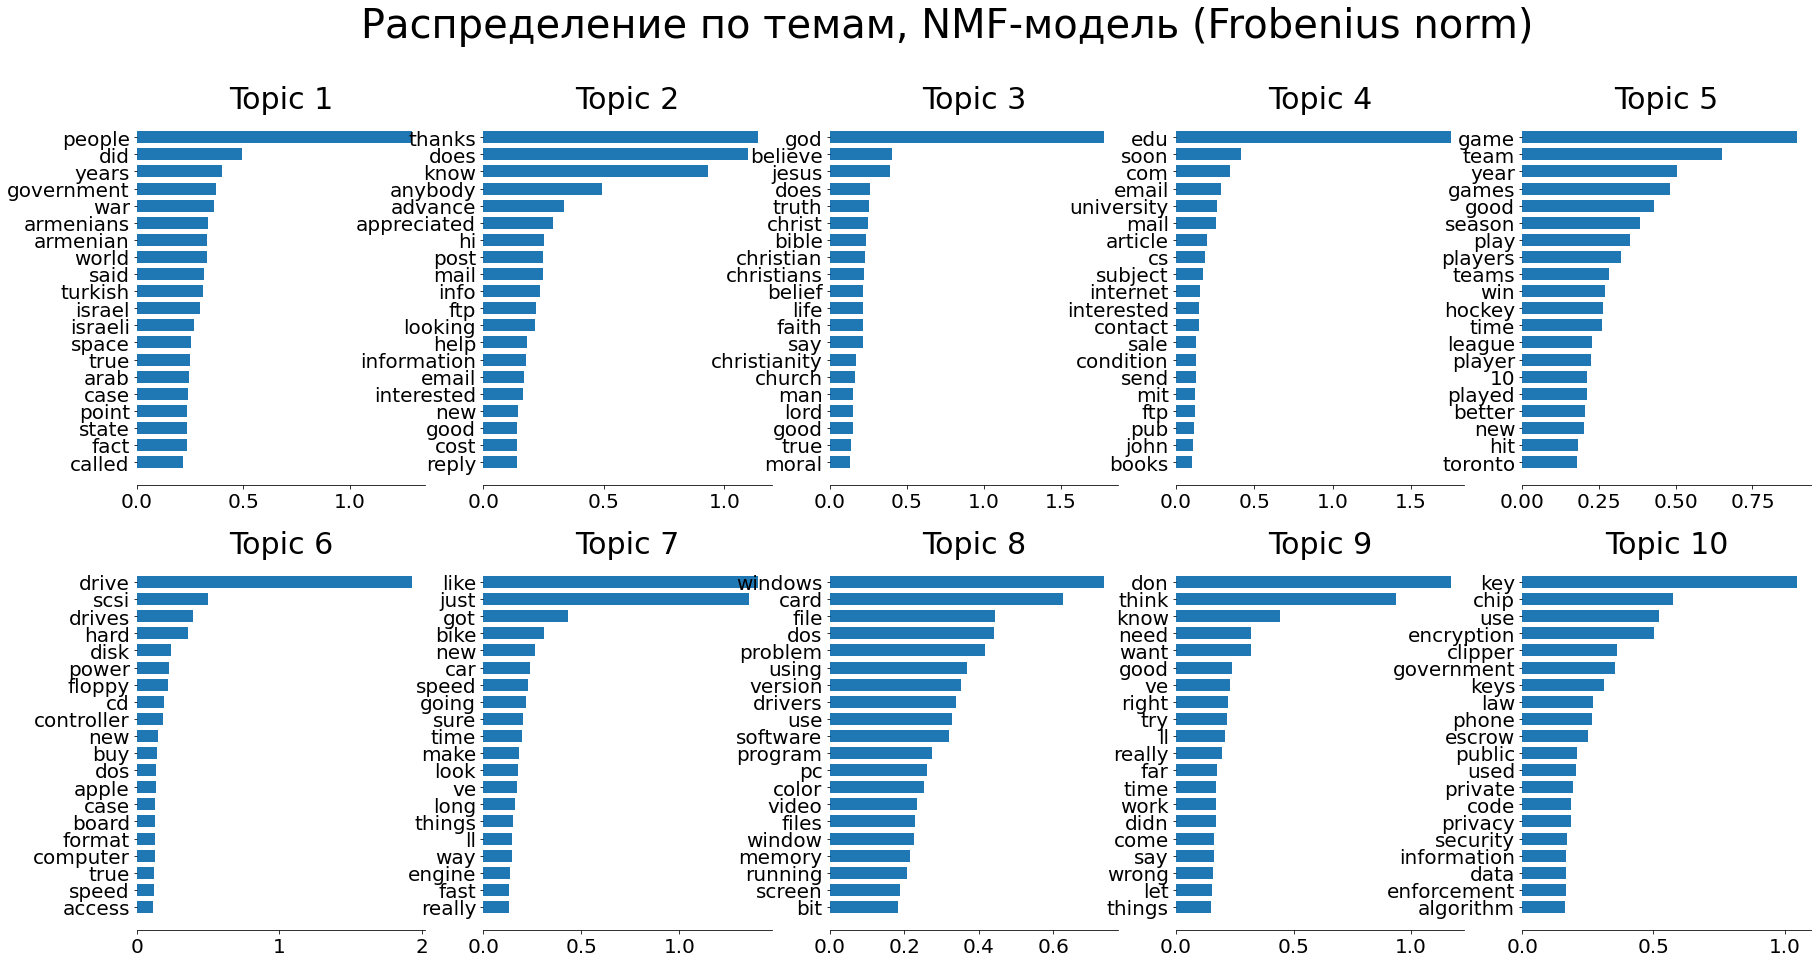

In [93]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Распределение по темам, NMF-модель (Frobenius norm)')

Для второй версии добавим параметров:

- beta-loss : мера оптимизации расстояния между матрицами (дивергенции)
- solver: еще один параметр оптимизации, для KL-дивергенции нужен Multiplicative Update ('mu')

In [94]:
# обучаем вторую модель

nmf = NMF(n_components=n_components, beta_loss='kullback-leibler', solver='mu').fit(tfidf)

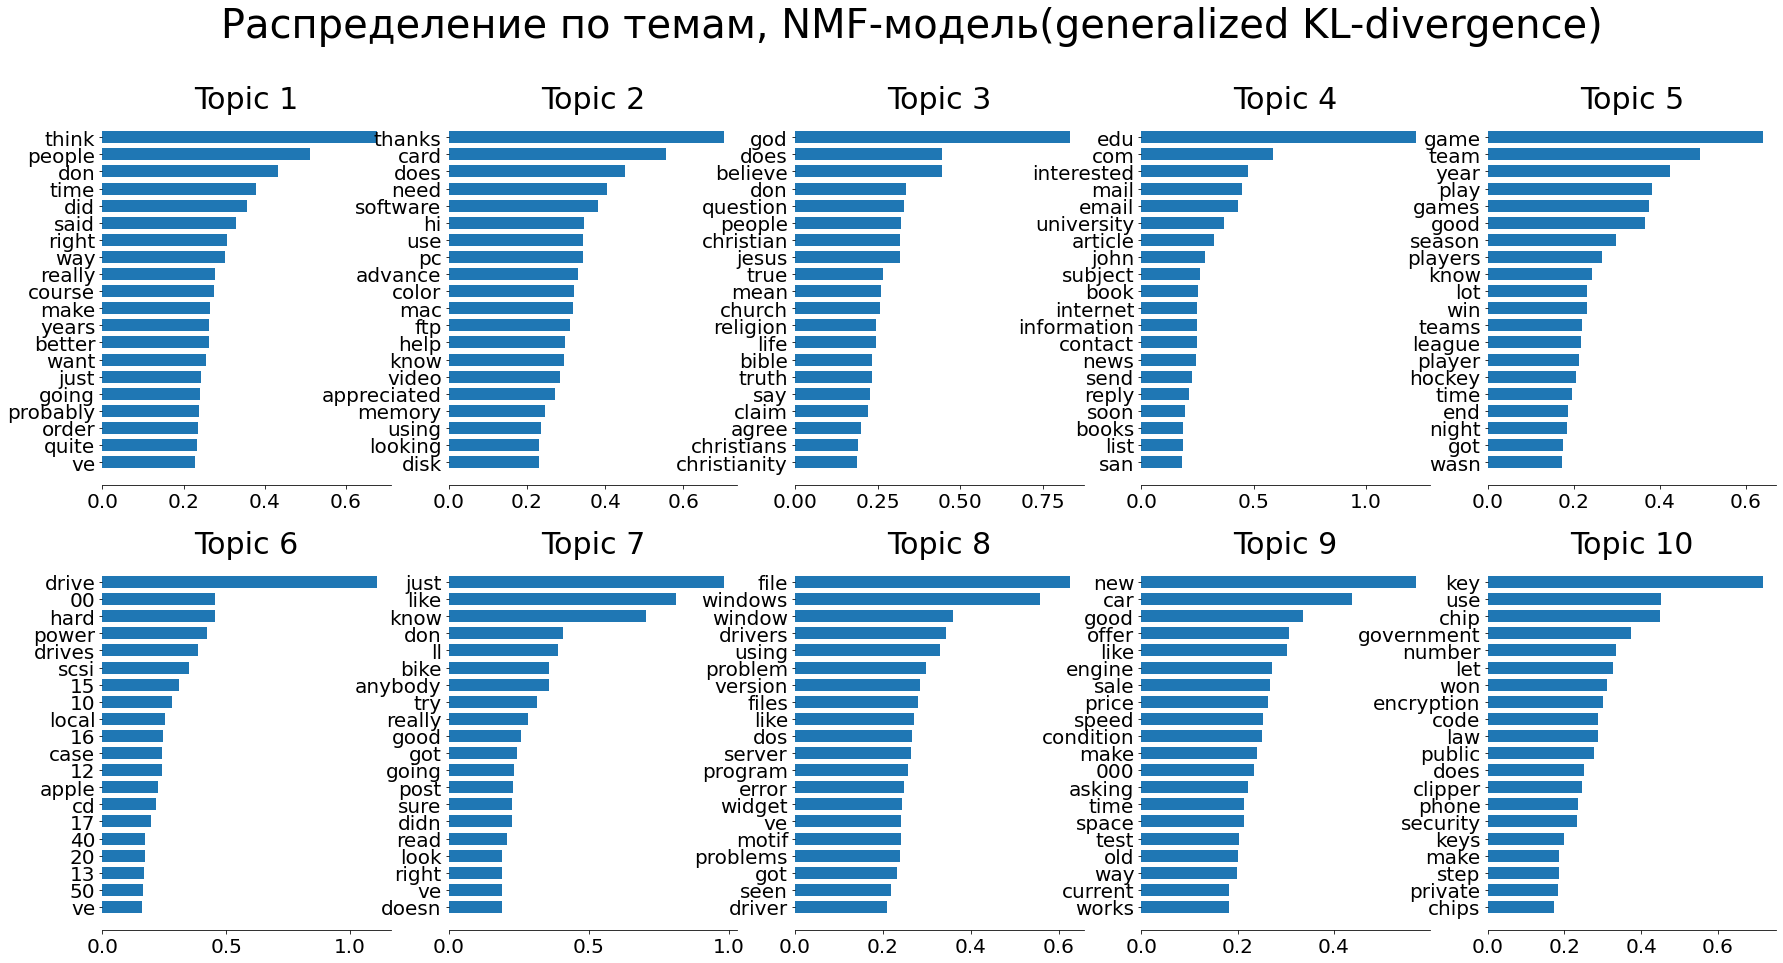

In [95]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Распределение по темам, NMF-модель(generalized KL-divergence)')

In [96]:
print_top_words(nmf, tfidf_feature_names, 20)

Topic #0:
think people don time did said right way really course make years better want just going probably order quite ve
Topic #1:
thanks card does need software hi use pc advance color mac ftp help know video appreciated memory using looking disk
Topic #2:
god does believe don question people christian jesus true mean church religion life bible truth say claim agree christians christianity
Topic #3:
edu com interested mail email university article john subject book internet information contact news send reply soon books list san
Topic #4:
game team year play games good season players know lot win teams league player hockey time end night got wasn
Topic #5:
drive 00 hard power drives scsi 15 10 local 16 case 12 apple cd 17 40 20 13 50 ve
Topic #6:
just like know don ll bike anybody try really good got going post sure didn read look right ve doesn
Topic #7:
file windows window drivers using problem version files like dos server program error widget ve motif problems got seen driver
To

In [97]:
nmf_topics = nmf.transform(tfidf) # docs x topics
nmf_topics.shape

(2000, 10)

In [98]:
for n in range(nmf_topics.shape[0])[:10]: # first 10 docs and their most relevant topics
    topic_most_pr = lsa_topic_matrix[n].argmax()+1
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

doc: 0 topic: 3

doc: 1 topic: 3

doc: 2 topic: 3

doc: 3 topic: 3

doc: 4 topic: 3

doc: 5 topic: 1

doc: 6 topic: 3

doc: 7 topic: 4

doc: 8 topic: 5

doc: 9 topic: 4

